# Home Credit Default


## Import Packages

First we start importing our packages.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
pd.set_option('display.max_columns', None)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, classification_report

Our data is in CSV format, so we'll do some cleanup as we import it and make sure our memory is lightweight.

In [3]:
def metadata_cleaning(dataset: str):
    df = pd.read_csv(r'../data/01_raw/'+dataset+'.csv')

    memory_ini = df.memory_usage().sum() / 1084**2

    df.columns = df.columns.str.lower()
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'object':
            try:
                df[col] = df[col].str.replace(' ', '_').str.lower().astype('category')
            except ValueError:
                pass

    memory_fin = df.memory_usage().sum() / 1084**2
    print(f'{dataset}: Memory usage before optimizing: {memory_ini:.2f} MB')
    print(f'{dataset}: Memory usage after optimizing: {memory_fin:.2f} MB')
    print(f'{dataset}: Size decreased by: {np.abs((memory_fin / memory_ini) -1):.1%}')

    return df

In [4]:
train = metadata_cleaning('application_train')
score = metadata_cleaning('application_test')

application_train: Memory usage before optimizing: 255.42 MB
application_train: Memory usage after optimizing: 226.11 MB
application_train: Size decreased by: 11.5%
application_test: Memory usage before optimizing: 40.15 MB
application_test: Memory usage after optimizing: 35.51 MB
application_test: Size decreased by: 11.6%


## Exploratory Data Analysis

### Target variable

target
0    91.927118
1     8.072882
Name: proportion, dtype: float64

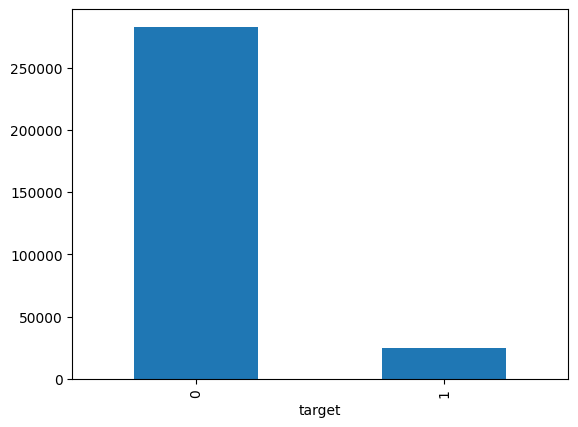

In [5]:
train.target.value_counts().plot.bar()
train.target.value_counts(normalize=True)*100

8% of the training set is a defaulter, while 92% does not. This means our data is imbalanced.

### Missing Data

In [6]:
pd.set_option('display.max_rows', None)
train.isna().mean().sort_values(ascending=False)[lambda x: x>0]

commonarea_medi                 0.698723
commonarea_avg                  0.698723
commonarea_mode                 0.698723
nonlivingapartments_mode        0.694330
nonlivingapartments_avg         0.694330
nonlivingapartments_medi        0.694330
fondkapremont_mode              0.683862
livingapartments_mode           0.683550
livingapartments_avg            0.683550
livingapartments_medi           0.683550
floorsmin_avg                   0.678486
floorsmin_mode                  0.678486
floorsmin_medi                  0.678486
years_build_medi                0.664978
years_build_mode                0.664978
years_build_avg                 0.664978
own_car_age                     0.659908
landarea_medi                   0.593767
landarea_mode                   0.593767
landarea_avg                    0.593767
basementarea_medi               0.585160
basementarea_avg                0.585160
basementarea_mode               0.585160
ext_source_1                    0.563811
nonlivingarea_mo

There's a missing data issue which needs to be addressed.

In [21]:
columns_missing_gt_50 = list((train.isna().mean().sort_values(ascending=False)[lambda x: x>.50]).index)
print(f'Columns with more than 50% missing data: {len(columns_missing_gt_50)}')

Columns with more than 50% missing data: 41


For columns with more than 50% of missing values, we are better off dropping them - but we should check if creating indicator variables can help us extract why the values are missing.

### Numeric Variables

Some things to note reading this:

- **flag_document_1 -- flag_document_21** represent if the client had a particular document.
- **amt_req_credit_bureau_hour** N of enquiries to Credit Bureau one hour before application 
- **amt_req_credit_bureau_day** N of enquiries to Credit Bureau one day before application (excluding one hour before application)
- **amt_req_credit_bureau_week** N of enquiries to Credit Bureau one week before application (excluding one day before application)
- **amt_req_credit_bureau_mon** N of enquiries to Credit Bureau one month before application (excluding one week before application)
- **amt_req_credit_bureau_qrt** N of enquiries to Credit Bureau 3 months before application (excluding one month before application)
- **amt_req_credit_bureau_year** N of enquiries to Credit Bureau one year before application (excluding 3 months before application)
- **sk_id_curr** is the index

### document_flags x target

,count,mean,std,min,25%,50%,75%,max
target,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
flag_document_2,307511.0,0.000042,0.006502,0.0,0.0,0.0,0.0,1.0
flag_document_3,307511.0,0.710023,0.453752,0.0,0.0,1.0,1.0,1.0
flag_document_4,307511.0,0.000081,0.009016,0.0,0.0,0.0,0.0,1.0
flag_document_5,307511.0,0.015115,0.122010,0.0,0.0,0.0,0.0,1.0
flag_document_6,307511.0,0.088055,0.283376,0.0,0.0,0.0,0.0,1.0
flag_document_7,307511.0,0.000192,0.013850,0.0,0.0,0.0,0.0,1.0
flag_document_8,307511.0,0.081376,0.273412,0.0,0.0,0.0,0.0,1.0
flag_document_9,307511.0,0.003896,0.062295,0.0,0.0,0.0,0.0,1.0
flag_document_10,307511.0,0.000023,0.004771,0.0,0.0,0.0,0.0,1.0


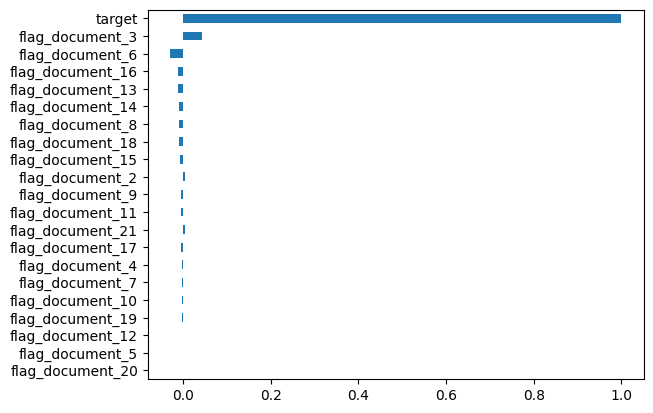

In [8]:
document_flags = [col for col in train.columns if col.startswith('flag_document')]
document_flags.insert(0, 'target')

(train
 [document_flags]
 .corr(method='spearman')
 .loc[:, 'target']
 # .iloc[1:]
 .sort_values(key=lambda val: abs(val))
 .plot
 .barh()
 # .style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)
train[document_flags].describe().T

There is little relationship between flag documents and the target.

### Amount Enquiries by Bureau x Target

,count,mean,std,min,25%,50%,75%,max
target,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
amt_req_credit_bureau_hour,265992.0,0.006402,0.083849,0.0,0.0,0.0,0.0,4.0
amt_req_credit_bureau_day,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
amt_req_credit_bureau_week,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
amt_req_credit_bureau_mon,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
amt_req_credit_bureau_qrt,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0
amt_req_credit_bureau_year,265992.0,1.899974,1.869295,0.0,0.0,1.0,3.0,25.0


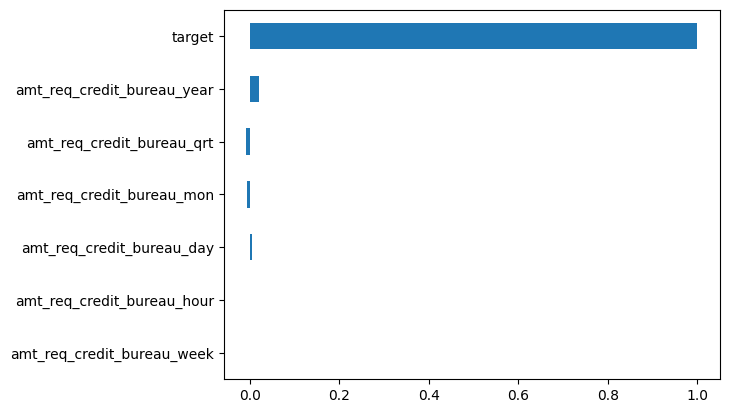

In [9]:
amt_variables = ['AMT_REQ_CREDIT_BUREAU_HOUR',
                'AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_MON',
                'AMT_REQ_CREDIT_BUREAU_QRT',
                'AMT_REQ_CREDIT_BUREAU_YEAR']
amt_variables = [x.lower() for x in amt_variables]
amt_variables.insert(0, 'target')

(train
 [amt_variables]
 .corr(method='spearman')
 .loc[:, 'target']
 # .iloc[1:]
 .sort_values(key=lambda val: abs(val))
 .plot
 .barh()
)
train[amt_variables].describe().T

There is no relationship between enquiries and the target.

### Kernel comparisons: target==1 vs target==0

AMT_CREDIT


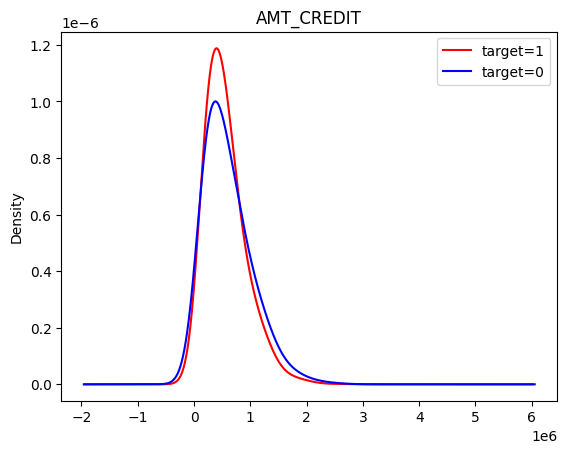



CNT_CHILDREN


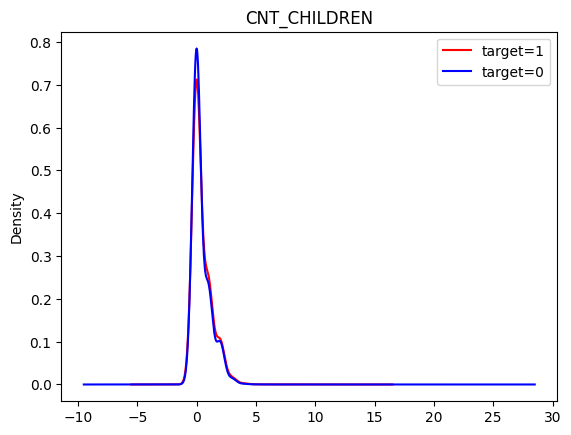



AMT_INCOME_TOTAL


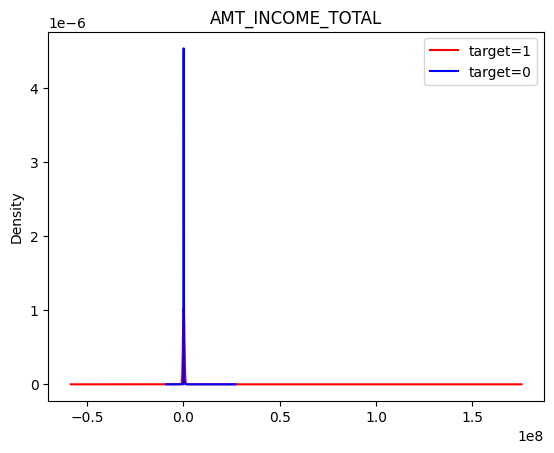



DAYS_BIRTH


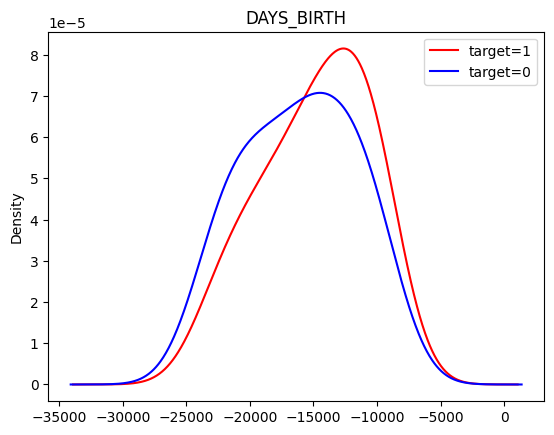



DAYS_EMPLOYED


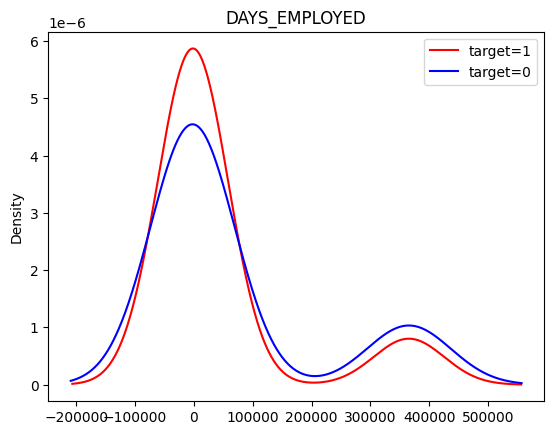



AMT_GOODS_PRICE


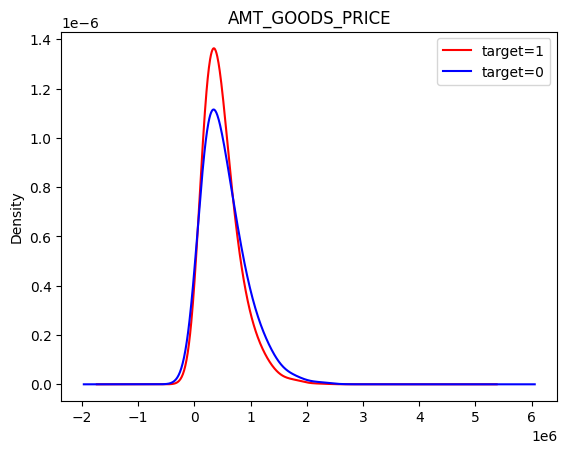



REGION_POPULATION_RELATIVE


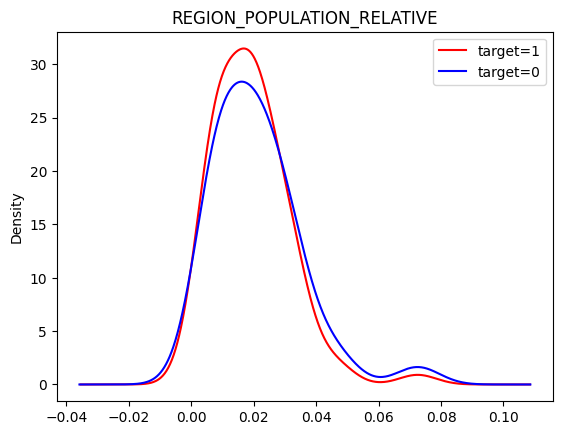



OWN_CAR_AGE


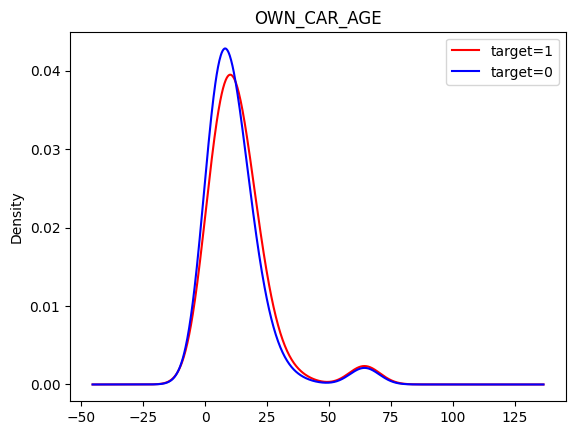



FLAG_MOBIL
LinAlgError, skipping


FLAG_EMP_PHONE


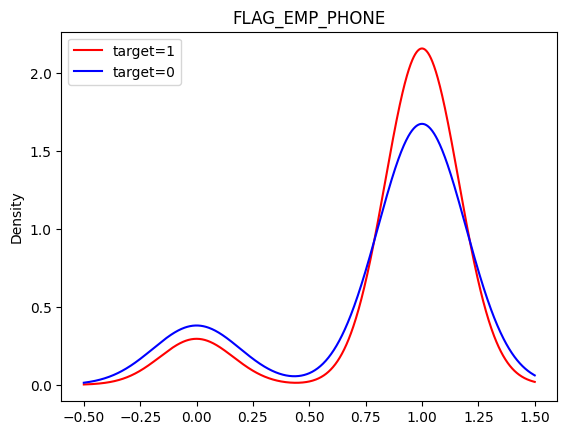



FLAG_WORK_PHONE


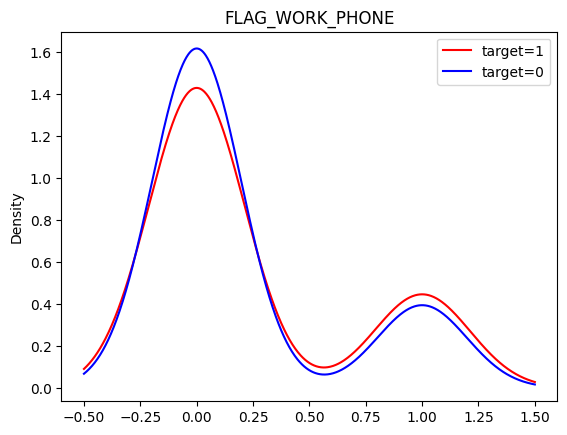



FLAG_CONT_MOBILE


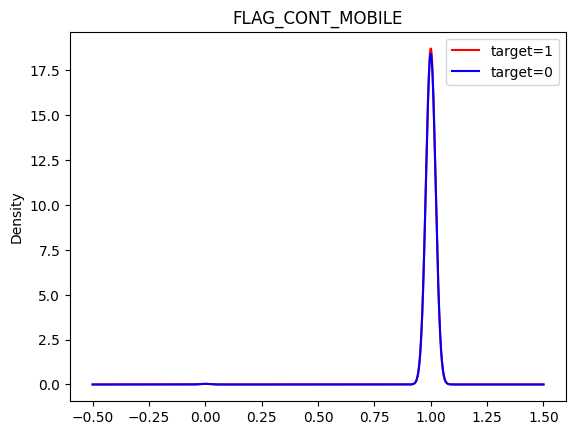



FLAG_PHONE


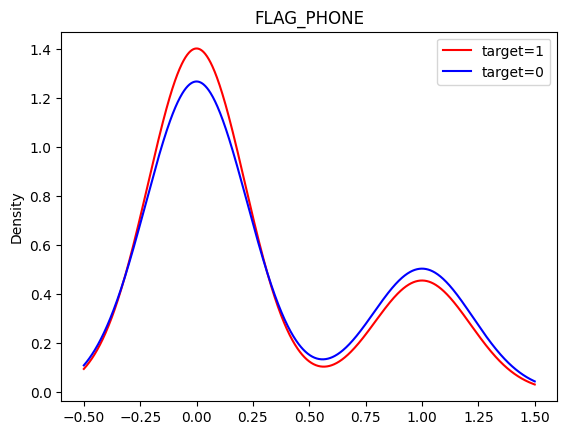



FLAG_EMAIL


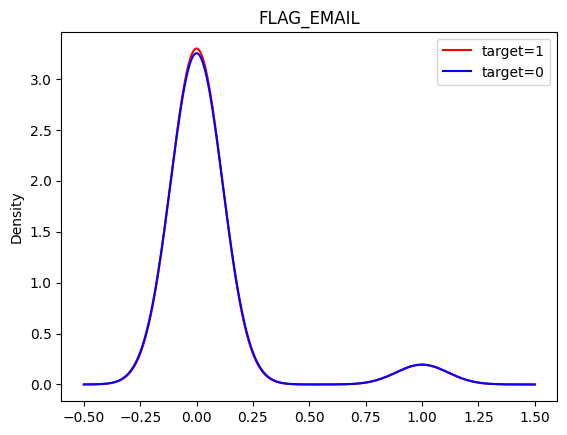



EXT_SOURCE_1


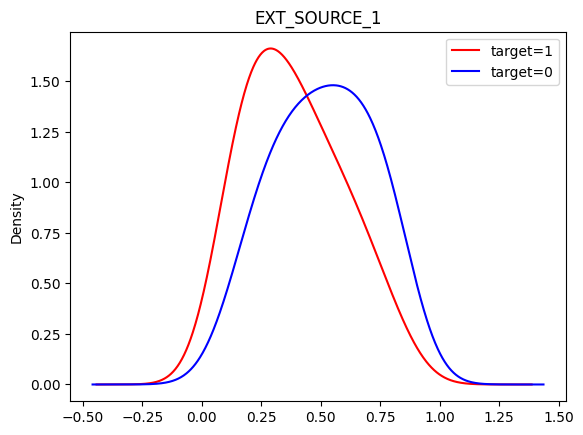



EXT_SOURCE_2


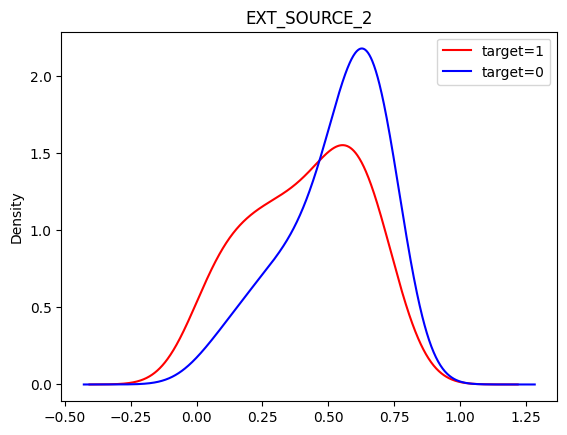



EXT_SOURCE_3


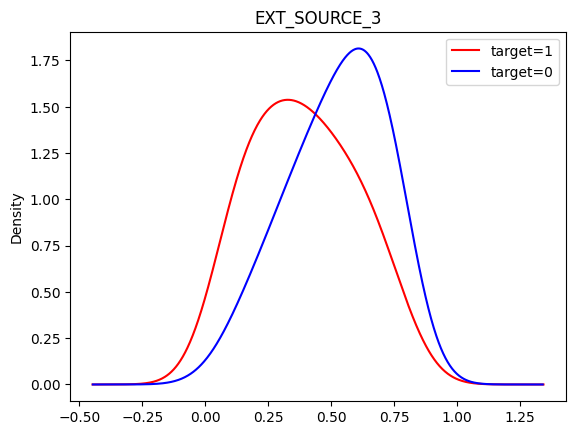



OBS_30_CNT_SOCIAL_CIRCLE


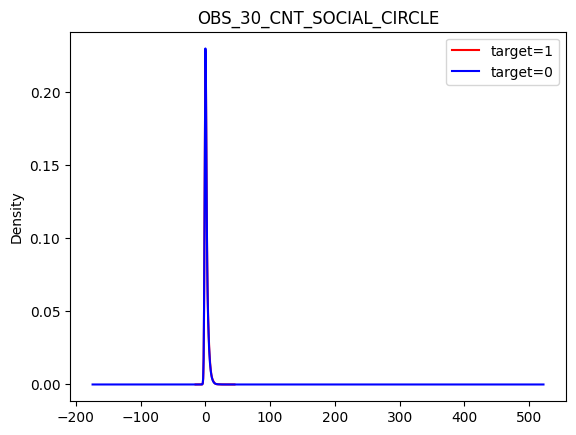



DEF_30_CNT_SOCIAL_CIRCLE


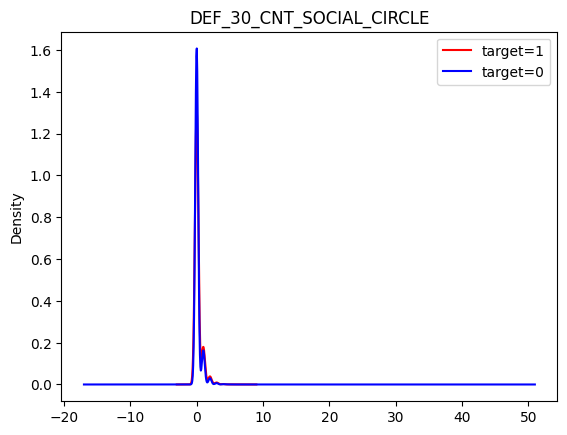



OBS_60_CNT_SOCIAL_CIRCLE


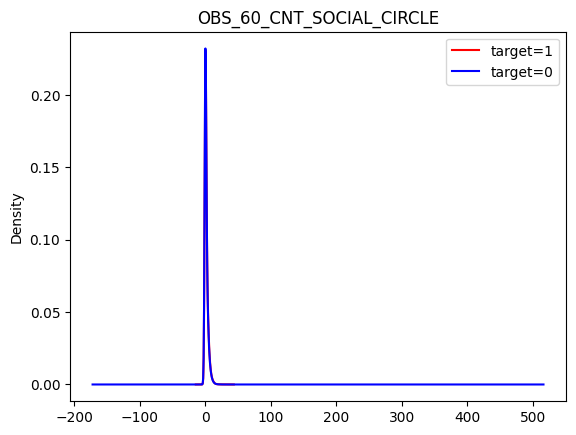



DEF_60_CNT_SOCIAL_CIRCLE


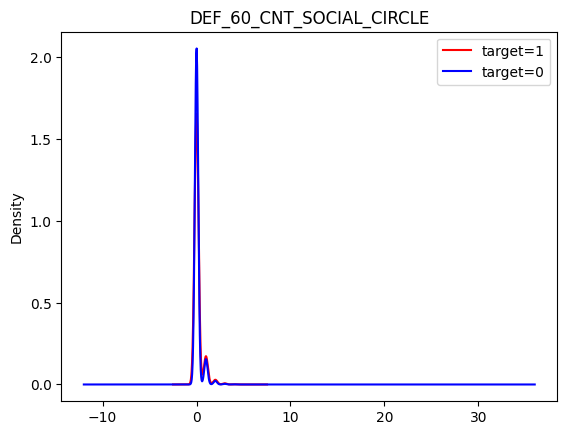



DAYS_LAST_PHONE_CHANGE


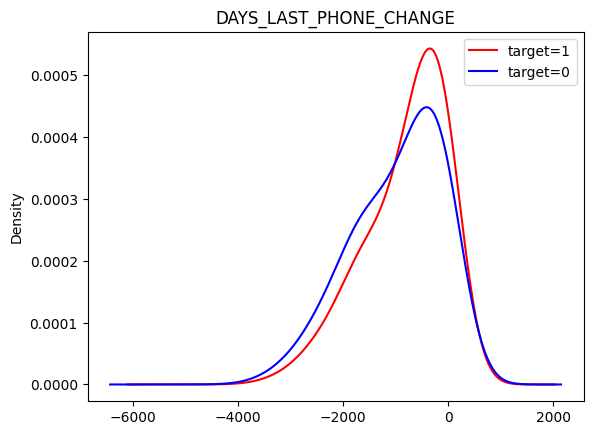

In [10]:
varlist = ['amt_credit', 'cnt_children', 'amt_income_total', 'days_birth', 'days_employed', 'amt_goods_price', 'region_population_relative', 
           'own_car_age', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'ext_source_1',
           'ext_source_2', 'ext_source_3', 'obs_30_cnt_social_circle', 'def_30_cnt_social_circle', 'obs_60_cnt_social_circle', 
           'def_60_cnt_social_circle', 'days_last_phone_change'
]
for var in varlist:
    print(f'{var.upper()}')
    try:
        train.loc[lambda df: df.target == 1][var].plot.kde(bw_method=0.5, legend=True, label='target=1', color='red')
        train.loc[lambda df: df.target == 0][var].plot.kde(bw_method=0.5, legend=True, label='target=0', color='blue', title=f'{var.upper()}')
        plt.show()
    except np.linalg.LinAlgError:
        print('LinAlgError, skipping')
    print('\n')

### Categorical Variables

In [11]:
cat_list = ['code_gender', 'name_education_type', 'name_family_status', 'occupation_type', 'organization_type']

,propension_target0,propension_target1
code_gender,,
m,89.858080,10.141920
f,93.000672,6.999328
xna,100.000000,0.000000


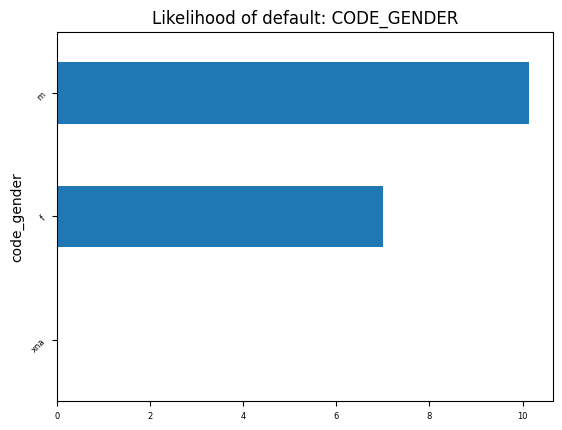

,propension_target0,propension_target1
name_education_type,,
lower_secondary,89.072327,10.927673
secondary_/_secondary_special,91.060071,8.939929
incomplete_higher,91.515034,8.484966
higher_education,94.644885,5.355115
academic_degree,98.170732,1.829268


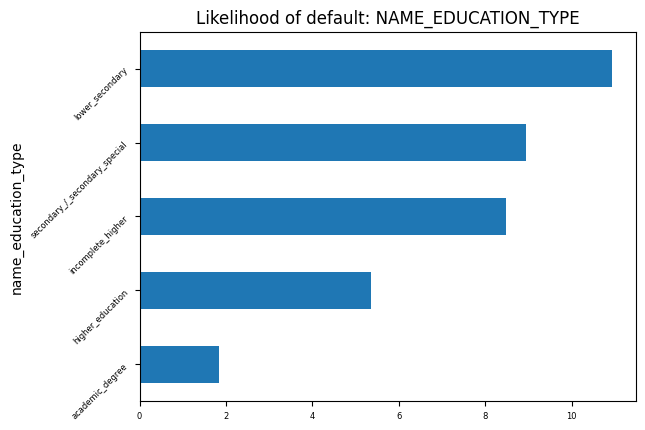

,propension_target0,propension_target1
name_family_status,,
civil_marriage,90.055416,9.944584
single_/_not_married,90.192325,9.807675
separated,91.805766,8.194234
married,92.440132,7.559868
widow,94.175783,5.824217
unknown,100.000000,0.000000


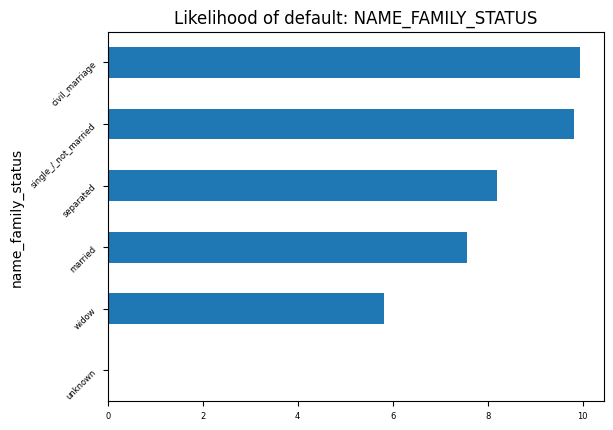

,propension_target0,propension_target1
occupation_type,,
low-skill_laborers,82.847587,17.152413
drivers,88.673870,11.326130
waiters/barmen_staff,88.724036,11.275964
security_staff,89.257551,10.742449
laborers,89.421230,10.578770
cooking_staff,89.556004,10.443996
sales_staff,90.368201,9.631799
cleaning_staff,90.393295,9.606705
realty_agents,92.143808,7.856192


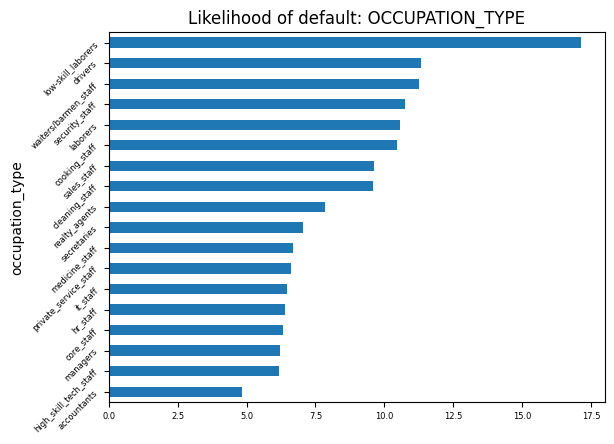

,propension_target0,propension_target1
organization_type,,
transport:_type_3,84.245998,15.754002
industry:_type_13,86.567164,13.432836
industry:_type_8,87.500000,12.500000
restaurant,88.293760,11.706240
construction,88.320190,11.679810
cleaning,88.846154,11.153846
industry:_type_1,88.931665,11.068335
industry:_type_3,89.383771,10.616229
realtor,89.393939,10.606061


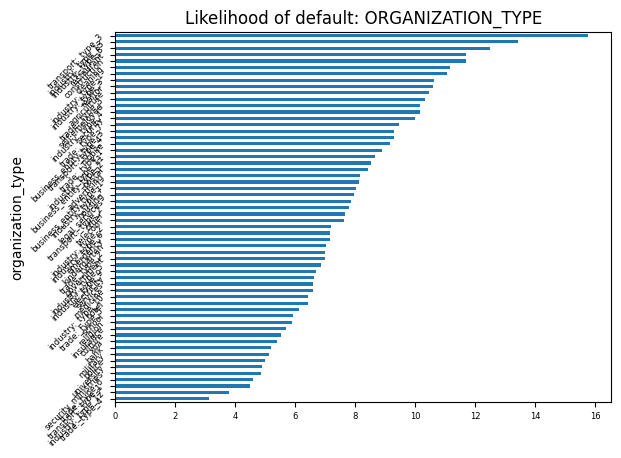

In [12]:
for cat in cat_list:

    display(pd.crosstab(train.target, train[cat])
     .T.reset_index()
     .merge(
         train.groupby(cat, observed=True).agg({'sk_id_curr': ['count']}).droplevel(0, axis=1).reset_index().rename(columns=({'count': 'total_by_group'})),
         how='left', on=cat
     )
     .assign(propension_target0=lambda df: df[0] / df.total_by_group * 100)
     .assign(propension_target1=lambda df: df[1] / df.total_by_group * 100)
     .set_index(cat)
     [['propension_target0', 'propension_target1']]
     .sort_values(by='propension_target1', ascending=False)
     .style.background_gradient(cmap='RdBu')
    )
    
    (pd.crosstab(train.target, train[cat])
     .T.reset_index()
     .merge(
         train.groupby(cat, observed=True).agg({'sk_id_curr': ['count']}).droplevel(0, axis=1).reset_index().rename(columns=({'count': 'total_by_group'})),
         how='left', on=cat
     )
     .assign(propension_target0=lambda df: df[0] / df.total_by_group * 100)
     .assign(propension_target1=lambda df: df[1] / df.total_by_group * 100)
     .set_index(cat)
     [['propension_target1']]
     .sort_values(by='propension_target1', ascending=True)
     .plot.barh(rot=45, fontsize=6, stacked=False, legend=False, title=f'Likelihood of default: {cat.upper()}')
    )

    plt.show()
    
    

## Feature Engineering

In [22]:
# Create variables
document_list = [x for x in train.columns if x.startswith('flag_document')]
external = [x for x in train.columns if x.startswith('ext')]
amt_list = [x for x in train.columns if x.startswith('amt_req_credit')]
drop_list = ['days_birth', 'sk_id_curr', 'days_employed', 'amt_credit', 'amt_income_total', 'amt_annuity']
columns_missing_gt_50.remove('ext_source_1')

train = (train
         .assign(document_flg=lambda dfx: dfx[document_list].sum(axis=1))
         .drop(document_list, axis=1)
         
         .assign(age=lambda dfx: dfx.days_birth/(-365))
         .assign(years_employed=lambda dfx: dfx.days_employed/(-365))
         .assign(avg_external=lambda dfx: dfx[external].mean(axis=1))
         .assign(days_employed=lambda df: df['days_employed'].replace(365243, np.nan))
         .assign(debt_to_income_ratio=lambda dfx: dfx.amt_credit / dfx.amt_income_total)
         .assign(code_gender=lambda df: df.code_gender.astype('object').replace('XNA', np.nan).astype('category'))
         .assign(income_class=lambda df: pd.qcut(df.amt_income_total, 3, labels=['low', 'medium', 'high']))
         .assign(annuity_class=lambda df: pd.qcut(df.amt_annuity, 3, labels=['low', 'medium', 'high']))
         .assign(credit_lt_100k=lambda df: np.where(df.amt_credit < 100_000, 1, 0))
         
         .drop(drop_list, axis=1)
         .drop(columns_missing_gt_50, axis=1)
         .drop(external, axis=1)
         .drop(amt_list, axis=1)
         )
score = (score
         .assign(document_flg=lambda dfx: dfx[document_list].sum(axis=1))
         .drop(document_list, axis=1)
         
         .assign(age=lambda dfx: dfx.days_birth/(-365))
         .assign(years_employed=lambda dfx: dfx.days_employed/(-365))
         .assign(avg_external=lambda dfx: dfx[external].mean(axis=1))
         .assign(days_employed=lambda df: df['days_employed'].replace(365243, np.nan))
         .assign(debt_to_income_ratio=lambda dfx: dfx.amt_credit / dfx.amt_income_total)
         .assign(code_gender=lambda df: df.code_gender.astype('object').replace('XNA', np.nan).astype('category'))
         .assign(income_class=lambda df: pd.qcut(df.amt_income_total, 3, labels=['low', 'medium', 'high']))
         .assign(annuity_class=lambda df: pd.qcut(df.amt_annuity, 3, labels=['low', 'medium', 'high']))
         .assign(credit_lt_100k=lambda df: np.where(df.amt_credit < 100_000, 1, 0))
         
         .drop(drop_list, axis=1)
         .drop(columns_missing_gt_50, axis=1)
         .drop(external, axis=1)
         .drop(amt_list, axis=1)
         )

In [23]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='target'),
                                                    train.target,
                                                    stratify=train.target,
                                                    test_size=0.4, random_state=42)

# Impute missing
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = num_imputer.fit_transform(X_train.select_dtypes('number'))
X_test_imputed = num_imputer.transform(X_test.select_dtypes('number'))

# Scaler
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_imputed)
X_test_scl = scaler.transform(X_test_imputed)

# # Dummies
X_train_cimputed = pd.get_dummies(X_train.select_dtypes('category'))
X_test_cimputed = pd.get_dummies(X_test.select_dtypes('category'))

# Preprocessed
X_train_complete = pd.concat([pd.DataFrame(X_train_scl, columns=X_train.select_dtypes('number').columns),
                              pd.DataFrame(np.array(X_train_cimputed), columns=X_train_cimputed.columns)
                             ], axis=1).drop('name_income_type_maternity_leave', axis=1).drop('name_family_status_unknown', axis=1)
X_test_complete = pd.concat([pd.DataFrame(X_test_scl, columns=X_test.select_dtypes('number').columns),
                             pd.DataFrame(np.array(X_test_cimputed), columns=X_test_cimputed.columns)
                            ], axis=1).drop('name_income_type_maternity_leave', axis=1).drop('name_family_status_unknown', axis=1)

# imputed_features_train.drop('name_income_type_maternity_leave', axis=1)
# imputed_features_train.drop('name_family_status_unknown', axis=1)

# Fit
clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=400)
clf.fit(X_train_complete, y_train)#.score(X_train, y_train)



LogisticRegression(max_iter=400, random_state=42)

In [24]:
print("model accuracy: %.3f" % clf.score(X_test_complete, y_test))
# roc_auc_score(X_test, y_test)

model accuracy: 0.919


In [25]:
y_pred = clf.predict_proba(X_test_complete)[:, 1]
y_pred
roc_auc_score(y_test, y_pred)

0.7411001333900648

In [26]:
y_hat = clf.predict_proba(X_train_complete)[:, 1]

In [27]:
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat)

In [28]:
roc_auc_test  = auc(fpr_test, tpr_test)
roc_auc_train  = auc(fpr_train ,tpr_train)

In [29]:
cm_test = confusion_matrix(y_test, clf.predict(X_test_complete))
cm_test

array([[112978,     97],
       [  9844,     86]], dtype=int64)

            fpr       tpr     1-fpr        tf  thresholds
10967  0.322556  0.677442  0.677444 -0.000002    0.078704


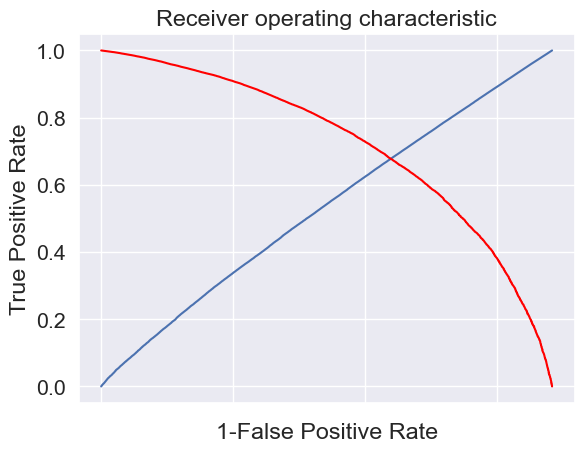

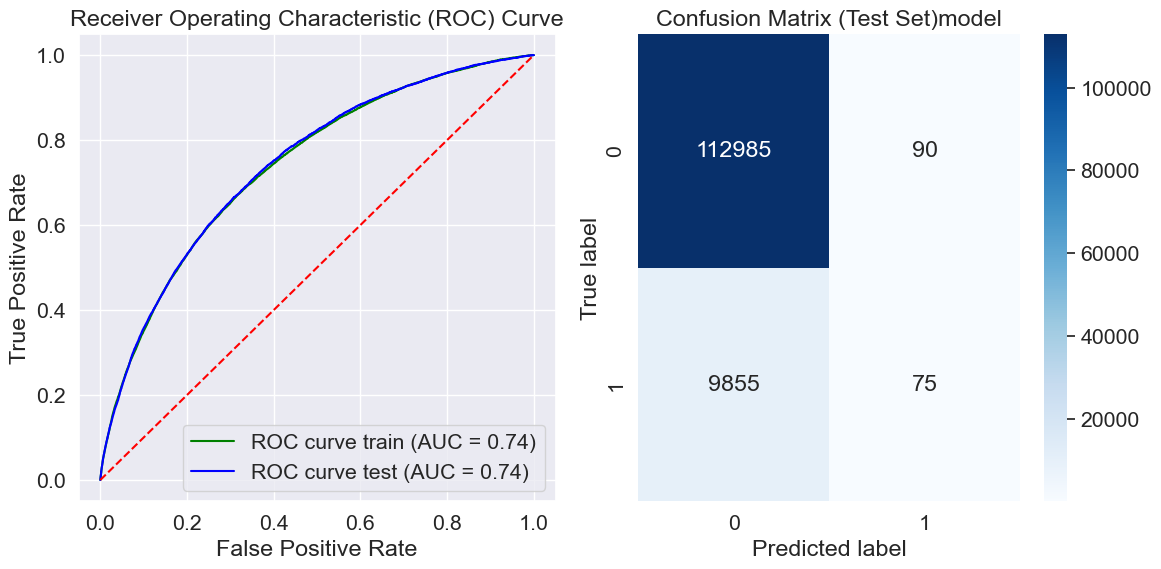

In [43]:
i = np.arange(len(tpr_test)) # index for df
roc = pd.DataFrame(
    {'fpr' : pd.Series(fpr_test, index=i),
     'tpr' : pd.Series(tpr_test, index = i), 
     '1-fpr' : pd.Series(1-fpr_test, index = i), 
     'tf' : pd.Series(tpr_test - (1-fpr_test), index = i), 
     'thresholds' : pd.Series(thresholds_test, index = i)
    }
)

print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot ROC curves on the first subplot
axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc="lower right")

sns.set(font_scale=1.4)
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')
axs[1].set_title('Confusion Matrix (Test Set)model');

plt.tight_layout()
plt.show()

## Tuning Logistic

In [37]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01, 0.1],
    'max_iter': [200, 300, 400]
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    scoring='roc_auc',
    cv=cv,
    verbose=0,# Evaluation metric
    n_jobs=cpu_count(),
    random_state=1
)

random_search.fit(X_train_complete, y_train)


C:\Users\Erich Kohn\envs\ml-312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Erich Kohn\envs\ml-312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Erich Kohn\envs\ml-312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Erich Kohn\envs\ml-312\Lib\site-packages\sklearn\linear_model\_logistic.py", line

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=1),
                   estimator=LogisticRegression(max_iter=400, random_state=42),
                   n_jobs=4,
                   param_distributions={'C': [0.001, 0.01, 0.1],
                                        'max_iter': [200, 300, 400],
                                        'penalty': ['l1', 'l2']},
                   random_state=1, scoring='roc_auc')

In [38]:
random_search.best_params_

{'penalty': 'l2', 'max_iter': 200, 'C': 0.1}

In [39]:
random_search.best_score_

0.7364459284491645

In [40]:
cm_test = confusion_matrix(y_test, random_search.predict(X_test_complete))
cm_test

array([[112985,     90],
       [  9855,     75]], dtype=int64)

            fpr       tpr     1-fpr        tf  thresholds
10967  0.322556  0.677442  0.677444 -0.000002    0.078704


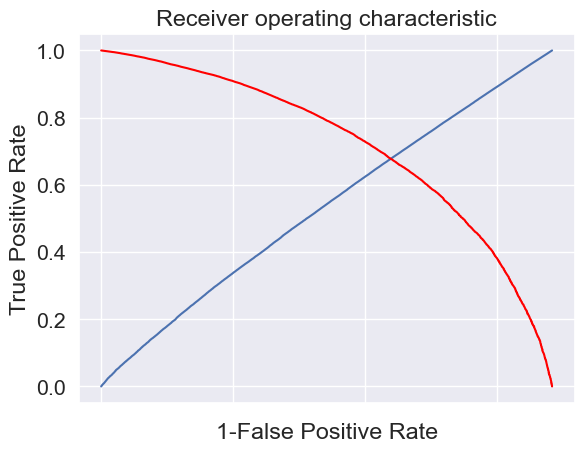

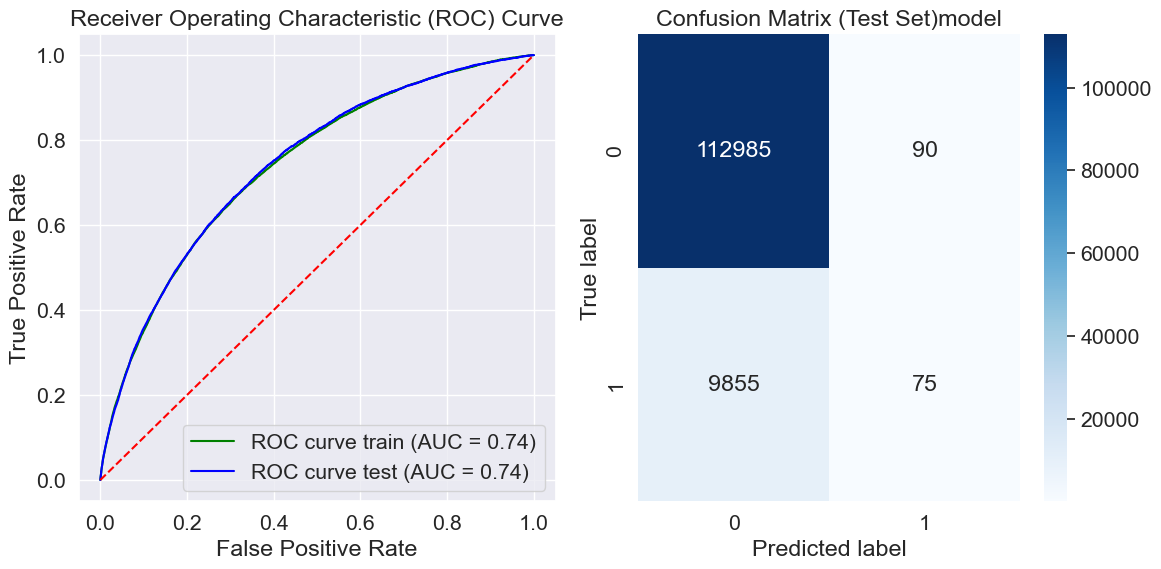

In [42]:
y_pred = random_search.predict_proba(X_test_complete)[:, 1]
y_hat = random_search.predict_proba(X_train_complete)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat)

roc_auc_test  = auc(fpr_test, tpr_test)
roc_auc_train  = auc(fpr_train ,tpr_train)

i = np.arange(len(tpr_test)) # index for df
roc = pd.DataFrame(
    {'fpr' : pd.Series(fpr_test, index=i),
     'tpr' : pd.Series(tpr_test, index = i), 
     '1-fpr' : pd.Series(1-fpr_test, index = i), 
     'tf' : pd.Series(tpr_test - (1-fpr_test), index = i), 
     'thresholds' : pd.Series(thresholds_test, index = i)
    }
)

print(roc.iloc[(roc.tf-0).abs().argsort()[:1]])

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot ROC curves on the first subplot
axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc="lower right")

sns.set(font_scale=1.4)
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')
axs[1].set_title('Confusion Matrix (Test Set)model');

plt.tight_layout()
plt.show()